## Big Data Project - Model1: Logistic Regression
### This file contain code and result of Logistic Regression trained on review of books.jsonl file


In [2]:
#importing the functions that will be needed ahead
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, when

### --Creating and building spark session with 2 maxExecutors with 50 partition

In [3]:
from pyspark.sql import SparkSession

# Creating a SparkSession
spark = (
  SparkSession.builder
    .appName("AmazonReviews")
    .master("yarn")
    .config("spark.dynamicAllocation.enabled", "true")
    .config("spark.shuffle.service.enabled",   "true")
    .config("spark.dynamicAllocation.minExecutors","1")
    .config("spark.dynamicAllocation.maxExecutors","2")
    .config("spark.sql.shuffle.partitions",       "50")
    .getOrCreate()
)


25/05/02 21:20:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### --Data Loading and preprocessing
#### I have turned my data as public so you should be able to run the below code, if there is problem while running then please let me know.

In [4]:
# Loadig the JSONL file into a Spark DataFrame
df = spark.read.json("gs://bigdataprojectdata/notebooks/jupyter/Books.jsonl")

# Checking the first few rows
df.show(5)

+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|      asin|helpful_vote|              images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|
+----------+------------+--------------------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+
|B09BGPFTDB|           0|[{IMAGE, https://...| B09BGPFTDB|   1.0|It is definitely ...|1642399598485|Not a watercolor ...|AFKZENTNBQ7A7V7UX...|             true|
|0593235657|           1|                  []| 0593235657|   5.0|Updated: after fi...|1640629604904|Updated: after 1s...|AFKZENTNBQ7A7V7UX...|             true|
|1782490671|           0|                  []| 1782490671|   5.0|I bought it for t...|1640383495102|Excellent! I love...|AFKZENTNBQ7A7V7UX...|             true|
|0593138228|           0|         

In [5]:
# Schema of the DataFrame
df.printSchema()


root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



In [6]:
#HANDLING MISSING VALUES
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|   0|           0|     0|          0|     0|   0|        0|    0|      0|                0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+



In [7]:
#counting the number of rows
print(f"Total number of reviews: {df.count()}")

Total number of reviews: 29475453


In [8]:
#Distribution of ratings
df.groupBy("rating").count().orderBy("rating", ascending=False).show()

+------+--------+
|rating|   count|
+------+--------+
|   5.0|20391478|
|   4.0| 4632932|
|   3.0| 2054057|
|   2.0| 1080897|
|   1.0| 1316085|
|   0.0|       4|
+------+--------+



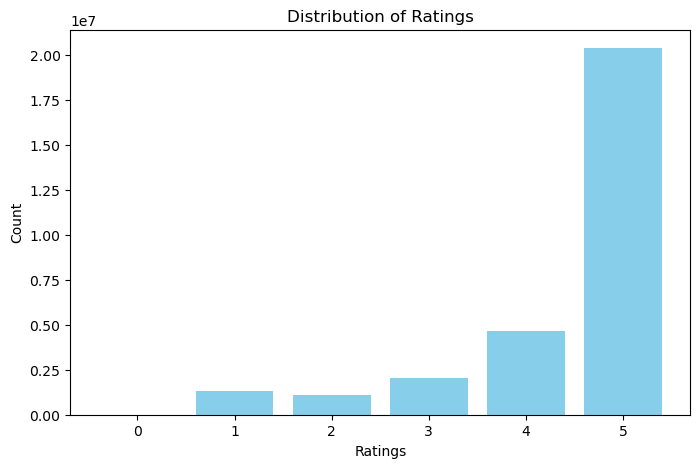

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas
rating_distribution = df.groupBy("rating").count().toPandas()

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(rating_distribution["rating"], rating_distribution["count"], color='skyblue')
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.xticks([0,1, 2, 3, 4, 5])  
plt.show()

### --Converting rating into binary sentiments with rating >=4 as positive and <=3 as negative

In [10]:
from pyspark.sql.functions import when
df = df.withColumn(
    "sentiment", 
    when(df["rating"] >= 4, "positive")
    .when(df["rating"] <= 3, "negative")
)

In [11]:
# Show the result
df.select("rating", "sentiment").show(5)

+------+---------+
|rating|sentiment|
+------+---------+
|   1.0| negative|
|   5.0| positive|
|   5.0| positive|
|   5.0| positive|
|   5.0| positive|
+------+---------+
only showing top 5 rows



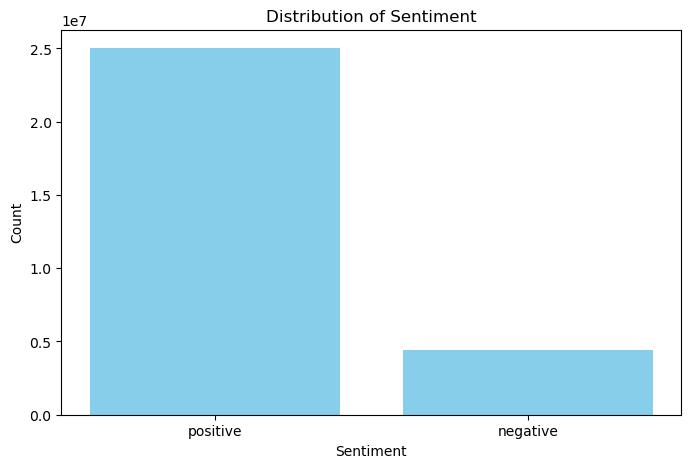

In [12]:
# Convert PySpark DataFrame to Pandas
sentiment_distribution = df.groupBy("sentiment").count().toPandas()

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(sentiment_distribution["sentiment"], sentiment_distribution["count"], color='skyblue')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiment")
plt.xticks(["positive", "negative"])  
plt.show()

In [13]:
sentiment_distribution

,sentiment,count
0,positive,25024410
1,negative,4451043


In [14]:
total_users = df.select("user_id").count()
distinct_users = df.select("user_id").distinct().count()

In [15]:
total_users, distinct_users

(29475453, 10297355)

### --Removing the duplicate row having same title and user_id i.e. person giving review to same book.

In [16]:
#duplicates with title and user_id
from pyspark.sql.functions import count

df.groupBy("title", "user_id").agg(count("*").alias("count")).filter("count > 1").show()

+--------------------+--------------------+-----+
|               title|             user_id|count|
+--------------------+--------------------+-----+
|It was easy readi...|AHGIINEPMSYEGB2F6...|    3|
|The Essential Ele...|AF62AEIOEKVHHD4XH...|    2|
|          Five Stars|AG3XDDXYJPVYLW7UE...|    2|
|          Five Stars|AFRM6UH4MF3PJYLRV...|    4|
|          Five Stars|AEAGCIMGDOZO4UE4K...|   73|
|          Five Stars|AFJALXX5GKQQDUFUM...|    4|
|       Great Journal|AGEU7G52QXBK7AAZB...|    2|
|          Five Stars|AG52GELBAMYR7UTMY...|    2|
|        Great series|AF6FMOYQJMKMEFZ7I...|    4|
|          Five Stars|AENJEKEKRPK7HFWR6...|    2|
|          Four Stars|AFRQ6WT64VPP4U6LK...|    2|
|          Five Stars|AE572POG7QXG7EW6L...|    6|
|          Five Stars|AH2UKOO4OVQZ2PTPA...|    4|
|          Five Stars|AGVTQFTFRKN53VVLF...|    6|
|          Five Stars|AF2NJ47ATOPCW7JVH...|    2|
|          Five Stars|AFQPHGIIJ3QXUA2X5...|    2|
|          Five Stars|AGXEMNB5RCZVOFT37...|    4|


In [17]:
df = df.dropDuplicates(["title", "user_id"])

In [18]:
df.count()

26658852

In [19]:
df.show(5)

+----------+------------+------+-----------+------+--------------------+-------------+-----+--------------------+-----------------+---------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|title|             user_id|verified_purchase|sentiment|
+----------+------------+------+-----------+------+--------------------+-------------+-----+--------------------+-----------------+---------+
|B01LZFL63S|           1|    []| B01LZFL63S|   5.0|Excellent histori...|1515112152372|    !|AEBUGZHYF5WKAJ34R...|             true| positive|
|1601786271|           0|    []| 1601786271|   5.0|A great wake-up f...|1567192773723|    !|AGACG7SU7YCHFIVSQ...|             true| positive|
|1698846436|           0|    []| 1698846436|   4.0|Una divertida y s...|1576787485841|    !|AHIPIUV26OE437VDH...|             true| positive|
|B07ZJ2G5H9|           1|    []| B07ZJ2G5H9|   5.0|I gave this book ...|1612282698143|    !|AHOIF2CJDC7RZD4Y6...|             true| positive|
|B01D0

In [20]:
df = df.select("text","rating", "sentiment")

### --Checking if reviews "text" is a proper review i.e. contains more than 3 words. Dropping all the rows which has text containg less that 4 words

In [21]:

df = (df
                         .withColumn("word_count", F.size(F.split(F.col("text"),r"\s+")))
                         .filter(F.col("word_count")>=4)
                         .drop("word_count")
    )
df

DataFrame[text: string, rating: double, sentiment: string]

In [22]:
df.show(20, truncate=50)

+--------------------------------------------------+------+---------+
|                                              text|rating|sentiment|
+--------------------------------------------------+------+---------+
|Excellent historical novel!  Stayed up every ni...|   5.0| positive|
|                     A great wake-up for preachers|   5.0| positive|
|Una divertida y satírica vista a un Puerto Rico...|   4.0| positive|
|I gave this book five stars because I enjoyed i...|   5.0| positive|
|                            5/5 came in condition!|   5.0| positive|
|This is amazing, and really gives fairy tales a...|   5.0| positive|
|Such a sweet heartwarming story. I love reading...|   4.0| positive|
|OK book, well developed and deep symbolism. WAR...|   2.0| negative|
|     Such high reviews. Such a disappointing read!|   1.0| negative|
|absolutely love this book has great pages and w...|   5.0| positive|
|Have read the first chapter and it's very gripp...|   5.0| positive|
|I don't agree with 

In [23]:
#checkign the counts of sentiment rows if they are balanced or not
counts_sentiments = (
    df
        .groupBy("sentiment")
        .agg(F.count("*").alias("review_count"))
        .orderBy("sentiment")
)
counts_sentiments.show()

+---------+------------+
|sentiment|review_count|
+---------+------------+
| negative|     4144151|
| positive|    21092380|
+---------+------------+



## --Random undersampling the majority class due to large class imbalance to 0.4 of current

In [24]:
fractions = {"positive": 0.4, "negative": 1.0}

df = df.sampleBy("sentiment", fractions, seed=42)

df.groupBy("sentiment") \
           .count() \
           .show()


+---------+-------+
|sentiment|  count|
+---------+-------+
| positive|8439257|
| negative|4144155|
+---------+-------+



# Logistic Regression training

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, 
    Tokenizer, 
    StopWordsRemover, 
    HashingTF, 
    IDF, 
    VectorAssembler
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


In [26]:
#labelling the tartget variable i.e. sentiment column
label_indexer = StringIndexer(inputCol="sentiment", outputCol="label")

In [27]:
#Tokenizing and removing stop words
tokenizer    = Tokenizer(inputCol="text", outputCol="words_raw")
stop_remover = StopWordsRemover(inputCol="words_raw", outputCol="words")

In [28]:
#Feature extraction using tf-idf
hashingTF = HashingTF(inputCol="words", outputCol="tf_features", numFeatures=2**14)
idf       = IDF(inputCol="tf_features", outputCol="tfidf_features")

In [29]:
#assembling features
assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")

In [30]:
#configuring logistic regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)


In [31]:
#Building pipeline
pipeline = Pipeline(stages=[
    label_indexer,
    tokenizer,
    stop_remover,
    hashingTF,
    idf,
    assembler,
    lr
])

In [32]:
#splitting the dataset into train and test
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
train_df = train_df.repartition(20).cache()
test_df  = test_df .repartition(20).cache()

In [33]:
lr_model = pipeline.fit(train_df)

25/05/02 23:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1397.5 KiB
25/05/02 23:30:03 WARN DAGScheduler: Broadcasting large task binary with size 1398.6 KiB
25/05/02 23:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1398.0 KiB
25/05/02 23:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1399.2 KiB
25/05/02 23:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1398.0 KiB
25/05/02 23:38:18 WARN DAGScheduler: Broadcasting large task binary with size 1399.2 KiB
25/05/02 23:38:18 WARN DAGScheduler: Broadcasting large task binary with size 1398.0 KiB
25/05/02 23:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1399.2 KiB
25/05/02 23:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1398.0 KiB
25/05/02 23:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1399.2 KiB
25/05/02 23:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1398.0 KiB
25/05/02 23:38:22 WAR

In [34]:
 predictions = lr_model.transform(test_df)

In [35]:
#Evaluating LR model
#1: Area under curve
bce = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",
                                    labelCol="label",
                                    metricName="areaUnderROC")
roc_auc = bce.evaluate(predictions)

25/05/02 23:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1516.4 KiB


In [36]:
# 1. Define a GCS path for your model
model_path = "gs://bigdataprojectdata/models/sentiment_lr"

# 2. Save (this creates a folder with metadata + data)
lr_model.write().overwrite().save(model_path)

print(f"Model saved to {model_path}")

Model saved to gs://bigdataprojectdata/models/sentiment_lr


## Evaluating Accuracy and F1-Score

In [37]:
mce = MulticlassClassificationEvaluator(labelCol="label",
                                         predictionCol="prediction",
                                         metricName="accuracy")
accuracy = mce.evaluate(predictions)

f1 = mce.setMetricName("f1").evaluate(predictions)

print(f"Test ROC AUC = {roc_auc:.4f}")
print(f"Test Accuracy = {accuracy:.4f}")
print(f"Test F1 Score = {f1:.4f}")

25/05/03 00:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1528.1 KiB
25/05/03 00:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1528.1 KiB


Test ROC AUC = 0.8987
Test Accuracy = 0.8140
Test F1 Score = 0.7997
